In [1]:
import warnings 
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import plotly_express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid", {"grid.color": ".7"})
import klib
from plotly.subplots import make_subplots
import sklearn
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

Pregnancies: To express the Number of pregnancies

Glucose: To express the Glucose level in blood

BloodPressure: To express the Blood pressure measurement

SkinThickness: To express the thickness of the skin

Insulin: To express the Insulin level in blood

BMI: To express the Body mass index

DiabetesPedigreeFunction: To express the likelihood of diabetes based on family history.

Age: To express the age

Outcome: To express the final result 1 is Yes and 0 is No

In [2]:
df = pd.read_csv('.\\diabetes.csv')

In [3]:
df.sample(5) 

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
733,2,106,56,27,165,29.0,0.426,22,0
243,6,119,50,22,176,27.1,1.318,33,1
613,6,105,80,28,0,32.5,0.878,26,0
391,5,166,76,0,0,45.7,0.340,27,1
240,1,91,64,24,0,29.2,0.192,21,0


In [4]:
# preimenovanje varijabli u lower case zbog laseg kucanja
df.columns= df.columns.str.lower()

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
bloodpressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
skinthickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
bmi,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
diabetespedigreefunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


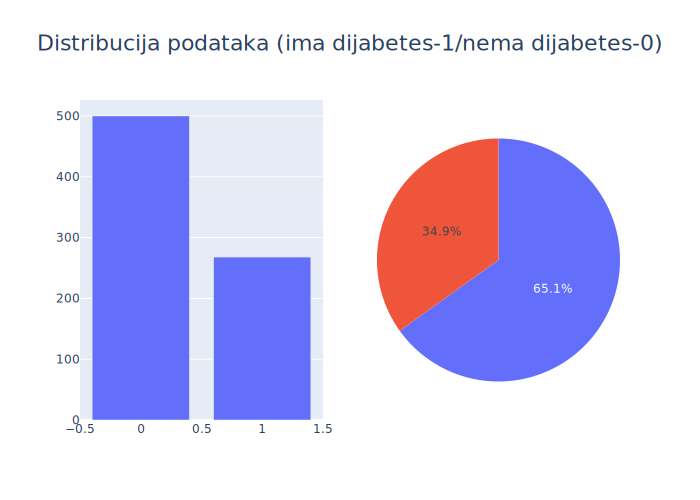

In [6]:
fig = make_subplots(rows=1, cols=2,specs=[[{'type':'xy'},{'type':'domain'}]])

fig.add_trace(go.Bar(x=df['outcome'].value_counts().index,y=df['outcome'].value_counts().values),row=1,col=1)
fig.add_trace(go.Pie(labels=df['outcome'].value_counts().index,values=df['outcome'].value_counts().values,),row=1,col=2)
fig.update_layout({'title':{'text':'Distribucija podataka (ima dijabetes-1/nema dijabetes-0)',
                            'x':0.5,'y':0.93,'font_size': 22}},showlegend=False,height=500)
fig.show('svg')

In [7]:
(df.corr()
  .style
  .background_gradient(cmap="RdBu", vmin=-1, vmax=1))

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome
pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
bloodpressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
skinthickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
bmi,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
diabetespedigreefunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


In [8]:
df.groupby(by='outcome')[['skinthickness','age']].mean()

,skinthickness,age
outcome,,
0,19.664000,31.190000
1,22.164179,37.067164



Iako je korelacija izmedju debljine koze i prisustva dijabetesa blizu nule (gotovo statisticki neznacajna) smatram da to nije slucaj jer dve varijable direktno uticu negativno jedna na drugu (Debljina koze i godine pacijenta). Koza gubi na elasticnosti i postaje **tanja** sto smo stariji, dok istovremeno postaje deblja tokom godina kod dijabeticara. U drugoj studiji sam naisao na podatak r = 0.53 (debljina koze i duzina trajanja bolesti)


Text(0.5, 1.0, 'Korelacija sa target varijablom - Outcome')

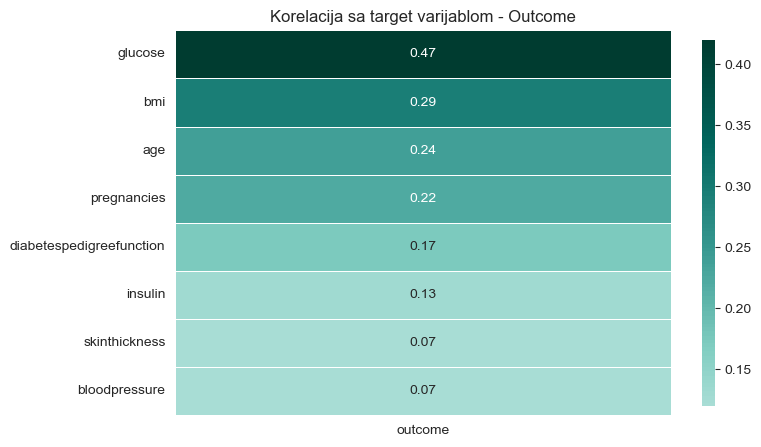

In [9]:
ax = klib.corr_plot(df, target='outcome', figsize=(8,5))
ax.set_title('Korelacija sa target varijablom - Outcome')

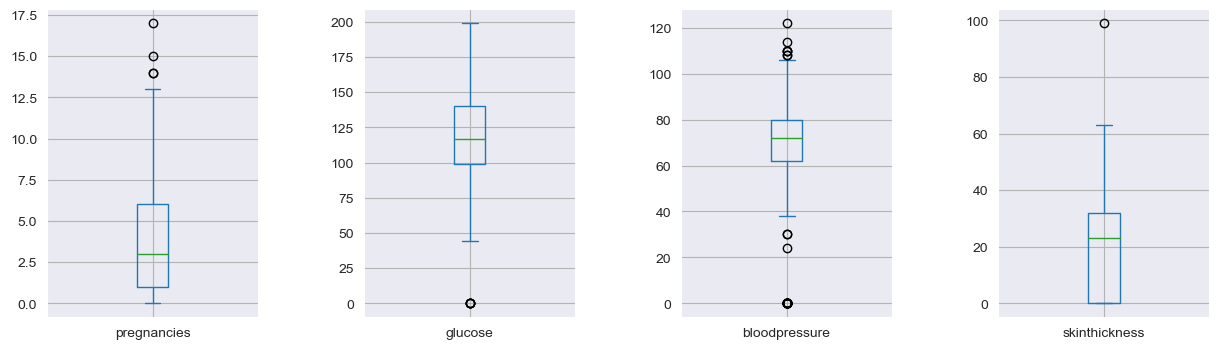

In [10]:
df.iloc[:,0:4].plot(
    kind='box', 
    subplots=True, 
    sharey=False, 
    figsize=(15, 4)
)

plt.subplots_adjust(wspace=0.5) 
plt.show()

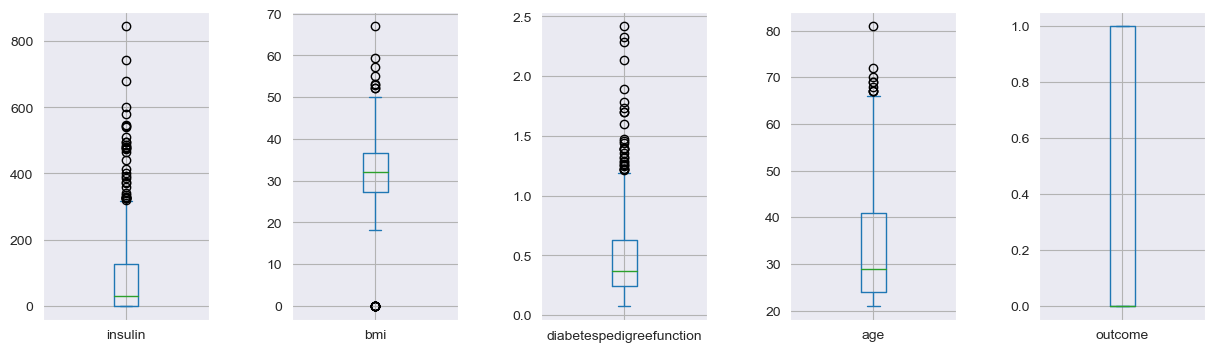

In [11]:
df.iloc[:,4:].plot(
    kind='box', 
    subplots=True, 
    sharey=False, 
    figsize=(15, 4)
)

plt.subplots_adjust(wspace=0.5) 
plt.show()

In [12]:
# Broj ljudi u dataset-u sa ocitanim nivoom insulina u krvi od 0 
len(df.loc[df['insulin']==0])

374

In [13]:
len(df.loc[df['skinthickness']==0])

227

Nalazenje ekstremnih vrednosti (Neke vrednosti cu ostaviti iako prelaze granicu za outlier-e po 1.5\*IQR metodi):

    - Potpuno odsustvo glukoze u krvi je nemoguce kod zive osobe tako da cu te vrednosti izbaciti
    - Mere za krvni pritisak su pretpostavljam ocitavanja dijastolnog (donjeg) pritiska tako da su mere ispod donje granice nemoguce dok cu gornje ostaviti jer su sa te strane ipak moguce. 
    - Debljina koze ima jednu ekstremnu vrednost koju cu ukloniti i pocinje od 0 sto je nemoguce *ALI* imamo 227 takvih vrednosti koje ne mogu da izbacim jer bismo izgubili ~1/3 podataka
    tako da cu ih zameniti srednjom vrednoscu.
    - U "celiji" iznad ove sam izvukao podatak da postoji 374 pacijenata sa nivoom insulina od 0 koji sam po sebi nije nemoguc scenario, cak veoma uobicajen kod pacijenata sa netretiranim (nelecenim, zapostavljenim) dijabetesom Tip 1 *ALI* ta brojka uveliko prevazilazi broj potvrdjenih dijabeticara u ovom setu podataka (268) i nejasno je sta se tu dogodilo.
    - Indeks telesne mase (BMI) od 0 nije moguc tako da cu te vrednosti zameniti jer ih nema puno a i distribucija je relativno normalna.

In [14]:
# izbacivanje maksimalne vrednosti od 99
df.drop(df['skinthickness'].idxmax(),inplace=True)

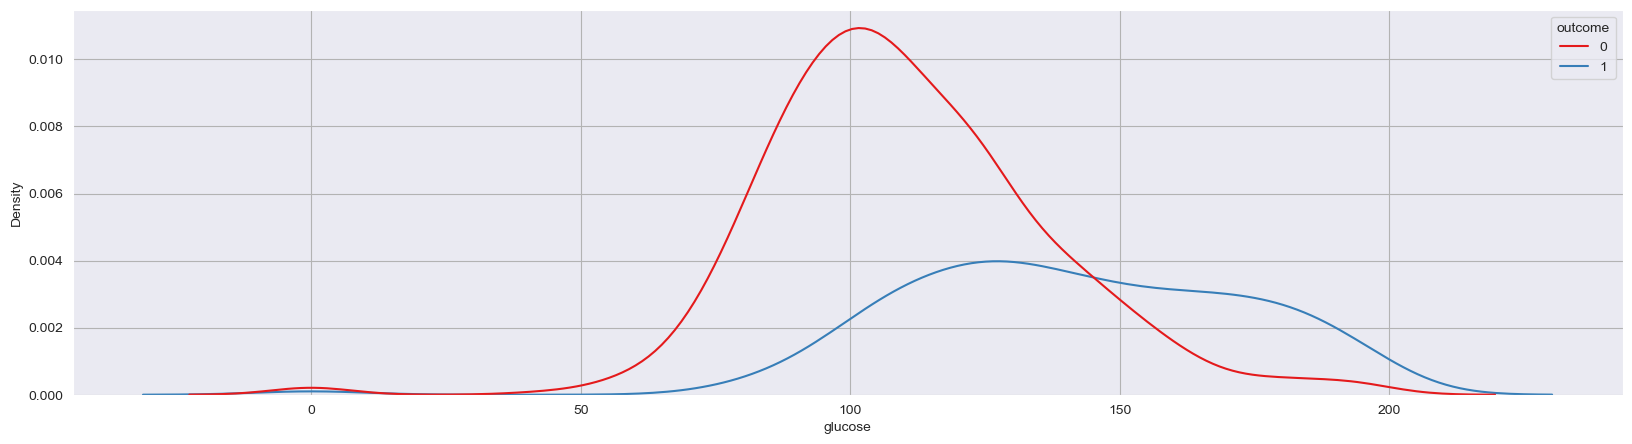

In [15]:
plt.figure(figsize=(20,5))
sns.kdeplot(data=df, x='glucose',hue='outcome', palette='Set1')
plt.show()

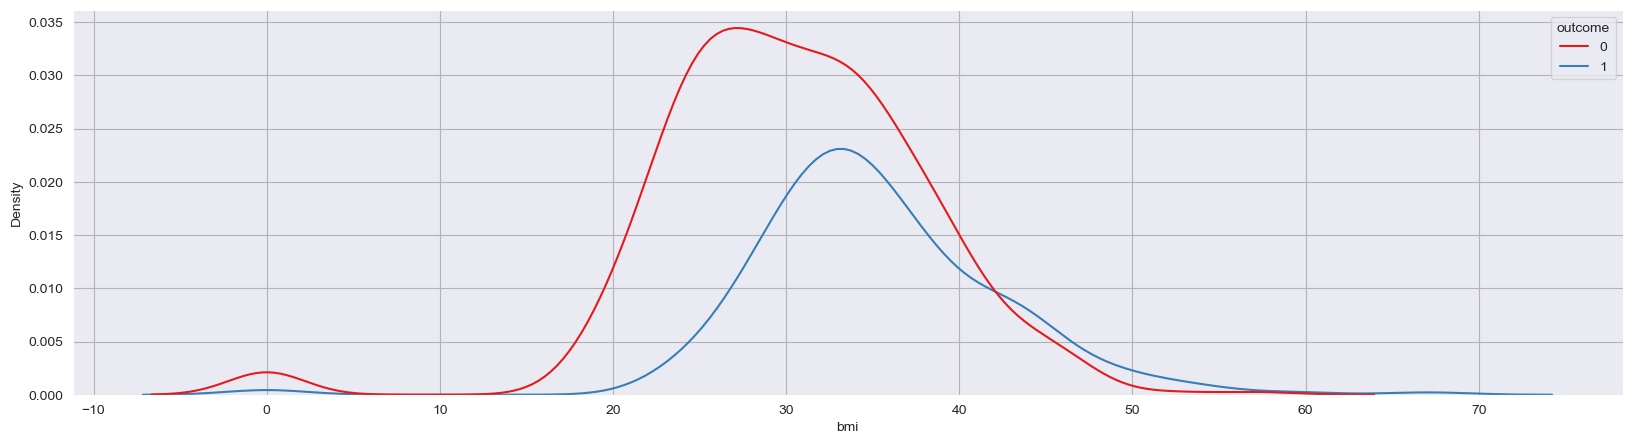

In [16]:
plt.figure(figsize=(20,5))
sns.kdeplot(data=df, x='bmi',hue='outcome', palette='Set1')
plt.show()

## Primprema podataka za masinsko ucenje

In [17]:
kolone = ["glucose","skinthickness","bmi","bloodpressure"]
for kol in kolone:
    median = df[kol].median()
    df.loc[df[kol]==0,kol] = median

In [18]:
df['outcome'] = df['outcome'].astype('category')

In [19]:
Q1 = np.percentile(df['bloodpressure'], 25,interpolation = 'midpoint')

Q3 = np.percentile(df['bloodpressure'], 75,interpolation = 'midpoint')
IQR = Q3 - Q1

upper = np.where(df['bloodpressure'] >= (Q3+1.5*IQR))

lower = np.where(df['bloodpressure'] <= (Q1-1.5*IQR))

df.drop(lower[0], inplace = True)

## Masinsko ucenje putem logisticke regresije

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
import scipy
from sklearn.preprocessing import StandardScaler, RobustScaler

In [21]:
X = df.drop('outcome', axis=1)
y = df['outcome']

In [22]:
X = RobustScaler().fit_transform(X)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

In [32]:
log = LogisticRegression()
log.fit(X_train, y_train)
predictions = log.predict(X_test)

In [33]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.81      0.90      0.85       153
           1       0.74      0.57      0.64        76

    accuracy                           0.79       229
   macro avg       0.77      0.73      0.75       229
weighted avg       0.79      0.79      0.78       229



In [30]:
print(confusion_matrix(y_test, predictions))

[[91  8]
 [26 28]]
